In [122]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [123]:
conn = psycopg2.connect(
  port='5432',
  host= "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user= "softtouchlenses_4e0b7c925f8444429457581f35678aea",
  password="softtouchlenses_4e0b7c925f8444429457581f35678aea_password",
  database= "softtouchlenses_4e0b7c925f8444429457581f35678aea_db"
)

In [124]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            o.total_price as order_amount,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [125]:
data = pd.read_sql(query1, conn)

In [126]:
data["order_date"] = pd.to_datetime(data["order_date"])
data[data["product_id"] == np.nan]
data = data.dropna()
data['WeekCount']=data['order_date'].dt.strftime('%Y-w%U')
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()

In [127]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [128]:
data = data[data['order_status'] != 'Cancelled']

In [129]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [130]:
Weekly_Stats = {}
productsegstats_weekly = {}
user_cohort_labels = ['New', 'Churned (Single Use Only)', 'Recent & Loyals', 'Champions', 'Churned (Repeat Use)']
user_cohort_var_list = ['Users']#, 'Orders', 'Recency', 'AOVContribution', 'OrderValue','MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV'
product_cohort_labels=['Hero', 'High Value & Slow Moving', 'Low Value & Slow Moving', 'New Business Drivers', 'Repeat Business Drivers']
product_cohort_var_list=['ProductCount'] #'Orders','Users','AverageSellingPrice','QuantityperCart','CartPenetration','NewUserRatio','NewOrders','ASPXQpC','AOVContribution','ProductCountMix','OrdersMix','UsersMix','AOVContribution(%)','OrderPerSKU'
final_stats = pd.DataFrame()
for x in output_list:
  x3 = data[data['WeekCount'] <= x]
  try:
    userweeklydata = x3.groupby("user_id").agg(
          Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: x.nlargest(2).min()),
          First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
          OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
          #Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          #Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
          ).reset_index()
    globalmaxdateweek=x3['order_date'].max()
    userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
    userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
    userweeklydata['MaturityAge']=np.nan
    userweeklydata.loc[userweeklydata['Frequency']>1,"MaturityAge"]=(userweeklydata['Last_Date']-userweeklydata['First_Date']).dt.days.abs()
    #userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
    #userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
    userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']
    r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
    #userweeklydata['f_score'] = userweeklydata['OrdersCount'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
    userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
   # userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
    userweeklydata['m_score']=0
    userweeklydata.loc[userweeklydata['MaturityAge'].notnull(),'m_score']= userweeklydata.loc[userweeklydata['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
    #userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
    #userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']
    def CohortLables_3(df):
      if ((df['Frequency']==1) & (df['r_score']>2)):
          return "New"
      elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
          return 'Churned (Single Use Only)'
      elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
          return 'Recent & Loyals'
      elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
          return 'Champions'
      else:
          return 'Churned (Repeat Use)'
    userweeklydata['User_Cohort_Label'] = userweeklydata.apply(CohortLables_3, axis=1)
    x3=pd.merge(x3,
         userweeklydata[['user_id','User_Cohort_Label']],
         on="user_id",
         how ='left')
    totalcarts=x3['order_id'].nunique()
    product_level=x3.groupby(['product_id']).agg(
            Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
            NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
            RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
    produser=data.groupby(['product_id','user_id']).agg(
        New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    produser_newcount=produser.groupby('product_id').agg(
        New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
    ).reset_index()
    data_repeat=data[data['TrxnRank']==2]
    produser_repeatcount=data_repeat.groupby('user_id').agg(
        Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
    k.fillna(0)
    k1=k.groupby('product_id').agg(
        Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
    ).reset_index()
    productlevel=pd.merge(product_level,produser_newcount, on='product_id', how='left')
    productlevel=pd.merge(productlevel,k1,on='product_id',how='left')
    productlevel['NewRepeatConversionRatio']=productlevel['Repeat_count']/productlevel['New_count']
    productlevel=productlevel.sort_values('NewRepeatConversionRatio')
    productlevel['CartPenetration']=productlevel['Carts']/totalcarts
    productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
    productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']
    CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
    productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
    productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
    productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
    productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
    productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
    def ProductCohortLables2(df):
        if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
            return 'Hero'
        elif df['NewRepeatConversion_score'] >2:
            return 'Repeat Business Drivers'
        elif (df['CP_score'] >2):
            return 'New Business Drivers'
        elif (df['ASP_score'] >3):
            return 'High Value & Slow Moving'
        elif (df['ASP_score'] <=3):
            return 'Low Value & Slow Moving'
        else:
            return 'Low Value & Slow Moving'
    productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)
    x3=pd.merge(x3,
         productlevel[['product_id','Product Cohort Lables']],
         on="product_id",
         how ='left')
    User_Product_Level=x3.groupby(['User_Cohort_Label','Product Cohort Lables']).agg(
        Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique'),
    ).reset_index()
    Weekly_Stats[x] = User_Product_Level
    x4 = data[data['WeekCount']==x]
    x5 = pd.merge(x4,userweeklydata[['user_id','User_Cohort_Label']], on='user_id', how='left')
    x5 = pd.merge(x5,productlevel[['product_id','Product Cohort Lables']], on='product_id', how='left')
    final_stats = final_stats.append(x5, ignore_index=True)
  except:
    pass

In [196]:
final_stats

,order_id,order_date,user_id,product_id,product_name,order_amount,order_status,quantity,sp,WeekCount,TrxnRank,New,Repeat,ordervalue,AOVContribution,DeltaDaysinOrders,DeltaOrderValues,User_Cohort_Label,Product Cohort Lables,Retention
0,3969073283246,2021-08-19,5425893015726,7.251689e+12,Affaires Magnetic Reading Spectacle Glasses Fo...,599.0,Delivered,1,599.0,2021-w33,1.0,1,0,599.0,0.256202,NaN,NaN,Churned (Single Use Only),Low Value & Slow Moving,0
1,3969315209390,2021-08-19,5426204672174,7.253567e+12,SOFLENS 59 - BAUSCH & LOMB (Monthly) (6 Lenses...,899.0,Delivered,1,899.0,2021-w33,1.0,1,0,899.0,0.384517,NaN,NaN,Churned (Single Use Only),New Business Drivers,0
2,3970425356462,2021-08-20,5427174932654,7.249161e+12,Power Swimming Goggles Aryca Rx Prescription O...,1399.0,Delivered,1,1399.0,2021-w33,1.0,1,0,1399.0,0.598375,NaN,NaN,New,High Value & Slow Moving,0
3,3972209148078,2021-08-20,5430117630126,7.253530e+12,Optima 38 DAILY WEAR LENS (1 Lens per Box) Bau...,1500.0,Delivered,2,450.0,2021-w33,1.0,1,0,900.0,0.384944,NaN,NaN,New,Hero,0
4,3972209148078,2021-08-20,5430117630126,7.253349e+12,Affaires Clear UV Contact Lenses Yearly Dispos...,1500.0,Delivered,1,600.0,2021-w33,1.0,1,0,600.0,0.256630,0.0,300.0,New,Low Value & Slow Moving,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28716,5237950054574,2023-12-19,6784937001134,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,1399.0,Delivered,1,1399.0,2023-w51,1.0,1,0,1399.0,0.598375,0.0,0.0,New,High Value & Slow Moving,0
28717,5237950054574,2023-12-19,6784937001134,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,1399.0,Delivered,1,1399.0,2023-w51,1.0,1,0,1399.0,0.598375,0.0,0.0,New,High Value & Slow Moving,0
28718,5237950054574,2023-12-19,6784937001134,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,1399.0,Delivered,1,1399.0,2023-w51,1.0,1,0,1399.0,0.598375,0.0,0.0,New,High Value & Slow Moving,0
28719,5237950054574,2023-12-19,6784937001134,7.249161e+12,Power Swimming Goggles FEIKE Rx Prescription O...,1399.0,Delivered,1,1399.0,2023-w51,1.0,1,0,1399.0,0.598375,0.0,0.0,New,High Value & Slow Moving,0


In [131]:
#AOV Contribution
final_stats['ordervalue']=final_stats['ordervalue']
final_stats['AOVContribution']=final_stats['ordervalue']/final_stats["order_id"].nunique()
final_stats['DeltaDaysinOrders']=(final_stats.groupby('user_id').order_date.shift() - final_stats.order_date).dt.days.abs()
final_stats['DeltaOrderValues']=(final_stats.groupby('user_id').ordervalue.shift() - final_stats.ordervalue)
weekly_summary_stats = final_stats.groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
            totalorders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            totalusers=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            totalvalue=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            SKUCounts=pd.NamedAgg(column='product_id', aggfunc='nunique')

      ).reset_index()
newdf=final_stats[final_stats['New']==1].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    newusercount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
     ).reset_index()
cancelled_orders = final_stats[final_stats['order_status'] == 'Cancelled'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()

delivered_orders = final_stats[final_stats['order_status'] == 'Delivered'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()
weekly_summary_stats = weekly_summary_stats.merge(newdf, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats =weekly_summary_stats.merge(cancelled_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats = weekly_summary_stats.merge(delivered_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats['repeatusercount']=weekly_summary_stats['totalusers']-weekly_summary_stats['newusercount']
weekly_summary_stats['AOV'] = weekly_summary_stats['totalvalue']/ weekly_summary_stats['totalorders']

In [132]:
weekly_summary_stats

,WeekCount,User_Cohort_Label,Product Cohort Lables,totalorders,totalusers,totalvalue,quantity,SKUCounts,newusercount,CancellationCount,DeliveryCount,repeatusercount,AOV
0,2021-w33,Churned (Single Use Only),Low Value & Slow Moving,1,1,599.0,1,1,1.0,NaN,1,0.0,599.000000
1,2021-w33,Churned (Single Use Only),New Business Drivers,1,1,899.0,1,1,1.0,NaN,1,0.0,899.000000
2,2021-w33,New,Hero,1,1,900.0,2,1,1.0,NaN,1,0.0,900.000000
3,2021-w33,New,High Value & Slow Moving,1,1,1399.0,1,1,1.0,NaN,1,0.0,1399.000000
4,2021-w33,New,Low Value & Slow Moving,1,1,600.0,1,1,1.0,NaN,1,0.0,600.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,2023-w51,Champions,Repeat Business Drivers,1,1,900.0,1,1,NaN,NaN,1,NaN,900.000000
1049,2023-w51,New,High Value & Slow Moving,3,3,50676.0,24,2,3.0,NaN,18,0.0,16892.000000
1050,2023-w51,New,Low Value & Slow Moving,3,3,6095.0,5,2,3.0,NaN,5,0.0,2031.666667
1051,2023-w51,New,New Business Drivers,4,4,55371.0,24,4,4.0,NaN,15,0.0,13842.750000


In [133]:
final_stats["Retention"] = 0
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 0) & (final_stats["DeltaDaysinOrders"] <= 90) , "Retention"] = "Retained"
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 90), "Retention"] = "Not-Retained"
retained_df = final_stats[final_stats['Retention'] == 'Retained'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).size().reset_index(name='Retained_Users')
weekly_summary_stats = pd.merge(weekly_summary_stats, retained_df, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")

In [134]:
key_metrices = ['WeekCount','User_Cohort_Label','Product Cohort Lables','totalorders', 'totalvalue', 'repeatusercount','newusercount', 'AOV']
weekly_summary_stats = weekly_summary_stats[key_metrices]

weekly_summary_stats = weekly_summary_stats.rename(columns={
    'totalorders':'Total_Orders',
    'totalvalue': 'Total_Value',
    'repeatusercount': 'No_of_Repeat_Users',
    'newusercount': 'No_of_New_Users(First_Time_Users)',
    'AOV': 'Average_Order_Value'
})
weekly_summary_stats=weekly_summary_stats.fillna(0)

In [135]:
weekly_summary_stats['AOV_Contribution'] = weekly_summary_stats['Total_Value'] / weekly_summary_stats.groupby('WeekCount')['Total_Orders'].transform('sum')

In [136]:
grouped_by_week = weekly_summary_stats.groupby('WeekCount')
dataframes_by_week = {}
for week, group in grouped_by_week:
    dataframes_by_week[week] = group.drop(columns='WeekCount').copy()

# Component 1

In [137]:
weekly_summary_stats["key"] = weekly_summary_stats["User_Cohort_Label"] + "-" + weekly_summary_stats["Product Cohort Lables"]
weekly_summary_stats.drop(['User_Cohort_Label', 'Product Cohort Lables'], axis=1, inplace=True)
weekly_summary_stats.set_index("WeekCount", inplace=True)

In [138]:
grouped_dict = {week: group for week, group in weekly_summary_stats.groupby(level='WeekCount')}
for week, df in grouped_dict.items():
    df = df.reset_index(drop=True)
    df.set_index('key', inplace=True)
    grouped_dict[week] = df

In [139]:
all_combinations = list(itertools.product(user_cohort_labels, product_cohort_labels))
formatted_combinations = [f'{user}-{product}' for user, product in all_combinations]

In [140]:
for key, df in grouped_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [141]:
averages_dict = {}
weeks = list(grouped_dict.keys())

for i in range(8, len(weeks)):
    week = weeks[i]
    df = grouped_dict[week]
    avg_df = df.rolling(window=8, min_periods=1).mean().shift(1)
    avg_df = avg_df.iloc[1:]
    averages_dict[week] = avg_df

In [142]:
for key, df in averages_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [143]:
result_list = []

for key, dataframe in grouped_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)

result_df_1= pd.concat(result_list, ignore_index=True)

In [144]:
result_df_melted_1 = pd.melt(result_df_1, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_1.rename(columns={'key': 'WeekCount'}, inplace=True)

In [145]:
result_list = []

for key, dataframe in averages_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T  # Convert sum_result to a DataFrame and transpose
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]  # Use the first index value
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)
result_df_2= pd.concat(result_list, ignore_index=True)

In [146]:
result_df_melted_2 = pd.melt(result_df_2, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_2.rename(columns={'key': 'WeekCount'}, inplace=True)

In [147]:
def create_metric_df(data_dict, metric_column):
    curr_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # curr_week_df = curr_week_df.append(temp_df, ignore_index=True)
        curr_week_df = pd.concat([curr_week_df, temp_df], ignore_index=True)

    curr_week_df = curr_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })

    return curr_week_df
curr_week_df = create_metric_df(grouped_dict, 'Total_Value')

In [148]:
def create_average_df(data_dict, metric_column):

    avg_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # avg_week_df = avg_week_df.append(temp_df, ignore_index=True)
        avg_week_df = pd.concat([avg_week_df, temp_df], ignore_index=True)

    avg_week_df = avg_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })
    return avg_week_df

avg_week_df = create_average_df(averages_dict, 'Total_Value')

In [193]:
def plotting_component_1(parameter, cohort):
    curr_week_df = create_metric_df(grouped_dict, parameter)
    avg_week_df = create_average_df(averages_dict, parameter)

    current_week_dataframe = pd.concat([result_df_melted_1, curr_week_df], axis=0)
    current_week_dataframe = current_week_dataframe.sort_values(by='WeekCount', ascending=True)
    current_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Current Week Value'}, inplace=True)
    keys_list = list(averages_dict.keys())
    current_week_dataframe = current_week_dataframe[current_week_dataframe['WeekCount'].isin(keys_list)]

    last_8_week_dataframe = pd.concat([result_df_melted_2, avg_week_df], axis=0)
    last_8_week_dataframe = last_8_week_dataframe.sort_values(by='WeekCount', ascending=True)
    last_8_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Last 8 Week Value'}, inplace=True)

    merged_dataframe = pd.merge(current_week_dataframe, last_8_week_dataframe, on=['WeekCount', 'Variables'], how='left')
    merged_dataframe = merged_dataframe.fillna(0)
    primary_explanatory_vars = ['Total_Orders', 'No_of_Repeat_Users', 'AOV_Contribution', 'No_of_New_Users(First_Time_Users)', '90_Day_Retention']
    target_vars = ["Total_Value"]
    merged_dataframe.loc[merged_dataframe['Variables'].isin(target_vars), 'Tag'] = 'Target_Variable'
    merged_dataframe.loc[merged_dataframe['Variables'].isin(primary_explanatory_vars), 'Tag'] = 'Primary_Explanatory'
    merged_dataframe.loc[merged_dataframe['Variables'].isin(formatted_combinations), 'Tag'] = 'Secondary_Explanatory'
    merged_dataframe['Difference'] = merged_dataframe['Current Week Value'] - merged_dataframe['Last 8 Week Value']

    new_df_1 = merged_dataframe[merged_dataframe["Tag"] == "Secondary_Explanatory"]
    new_df_1[['User_Cohort_Lables', 'Product_Cohort_Lables']] = new_df_1['Variables'].str.split('-', expand=True)

    
    
    df_agg = new_df_1.groupby(['WeekCount', cohort])['Current Week Value'].sum().reset_index()
    pivot_df = df_agg.pivot(index='WeekCount', columns=cohort, values='Current Week Value')
    pivot_df = pivot_df.tail(52)
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6))
    plt.title(f'Week on week {" ".join(parameter.split("_"))} by {" ".join(cohort.split("_"))}')
    plt.xlabel('Week Count')
    plt.ylabel(f'{" ".join(parameter.split("_"))}')
    ax.tick_params(axis='x')
    plt.show()

    return pivot_df

In [195]:
merged_dataframe[merged_dataframe["WeekCount"] == "2023-w51"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
3503,2023-w51,Churned (Single Use Only)-Repeat Business Drivers,0.000000,27340.750000,Secondary_Explanatory,-27340.750000
3504,2023-w51,Recent & Loyals-Hero,0.000000,26578.875000,Secondary_Explanatory,-26578.875000
3505,2023-w51,Recent & Loyals-High Value & Slow Moving,0.000000,19657.500000,Secondary_Explanatory,-19657.500000
3506,2023-w51,Recent & Loyals-Low Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory,0.000000
3507,2023-w51,Recent & Loyals-New Business Drivers,0.000000,0.000000,Secondary_Explanatory,0.000000
3508,2023-w51,Churned (Repeat Use)-High Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory,0.000000
3509,2023-w51,Churned (Repeat Use)-Low Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory,0.000000
3510,2023-w51,Champions-Hero,0.000000,0.000000,Secondary_Explanatory,0.000000
3511,2023-w51,Champions-High Value & Slow Moving,0.000000,0.000000,Secondary_Explanatory,0.000000
3512,2023-w51,Churned (Single Use Only)-New Business Drivers,0.000000,33675.250000,Secondary_Explanatory,-33675.250000


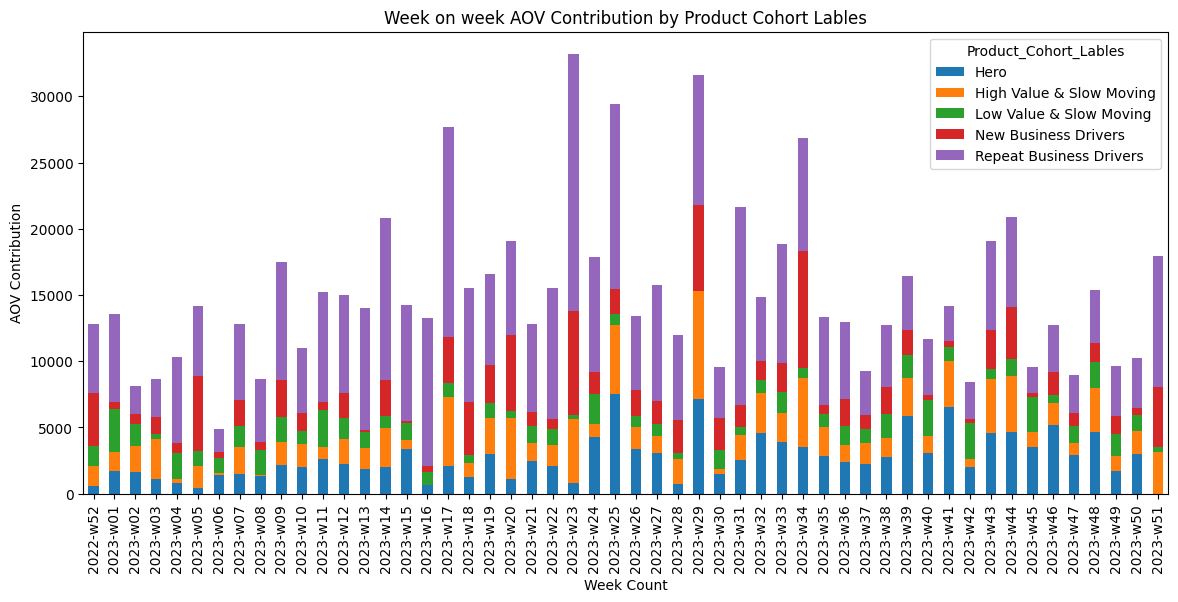

In [194]:
component_1 = plotting_component_1("AOV_Contribution", "Product_Cohort_Lables")

In [189]:
component_1

Product_Cohort_Lables,Hero,High Value & Slow Moving,Low Value & Slow Moving,New Business Drivers,Repeat Business Drivers
WeekCount,,,,,
2022-w52,15180.0,42020.0,40573.0,107516.0,140215.0
2023-w01,40408.0,34480.0,77896.0,14130.0,158850.0
2023-w02,26700.0,31100.0,26615.0,11497.0,34177.0
2023-w03,19023.0,51070.0,6995.0,21297.0,48645.0
2023-w04,17940.0,6800.0,43484.0,15875.0,143404.0
2023-w05,14700.0,52600.0,35135.0,181247.0,170398.0
2023-w06,38251.0,3388.0,31788.0,10633.0,48762.0
2023-w07,49698.0,66984.0,50883.0,66256.0,189206.0
2023-w08,54748.0,1399.0,74617.0,25018.0,190550.0


# Component 2

In [151]:
combinations = list(itertools.product(user_cohort_labels, product_cohort_labels))
combinations_df_by_week = pd.DataFrame(combinations, columns=['User_Cohort_Label', 'Product Cohort Lables'])

In [152]:
for df_name, df in dataframes_by_week.items():
    merged_df = pd.merge(
        combinations_df_by_week,
        df,
        how='outer',
        on=['User_Cohort_Label', 'Product Cohort Lables']
    )
    merged_df.fillna(0, inplace=True)
    dataframes_by_week[df_name] = merged_df

In [153]:
def week_metric_user_product_split(week, parameter):
  week_df = dataframes_by_week[week]
  pivot_df = week_df.pivot_table(index='User_Cohort_Label', columns='Product Cohort Lables', values=parameter, aggfunc='sum')
  return pivot_df

In [185]:
def get_component_2(week, parameter, cohort):
    week_data_df = week_metric_user_product_split(week, parameter)
    if cohort == "User_Cohort_Label":
        to_plot_df = week_data_df.sum(axis = 1).reset_index()
        to_plot_df.columns = [cohort, parameter]
    else:
        to_plot_df = week_data_df.sum(axis = 0).reset_index()
        to_plot_df.columns = [cohort, parameter]
    ax = to_plot_df.plot.bar(x=cohort, y=parameter, legend=False, rot=45)
    ax.set_ylabel(" ".join(parameter.split("_")))
    ax.set_xlabel(" ".join(cohort.split("_")))
    ax.set_title(f'{" ".join(parameter.split("_"))} distribution for each {" ".join(cohort.split("_"))}')
    plt.show()

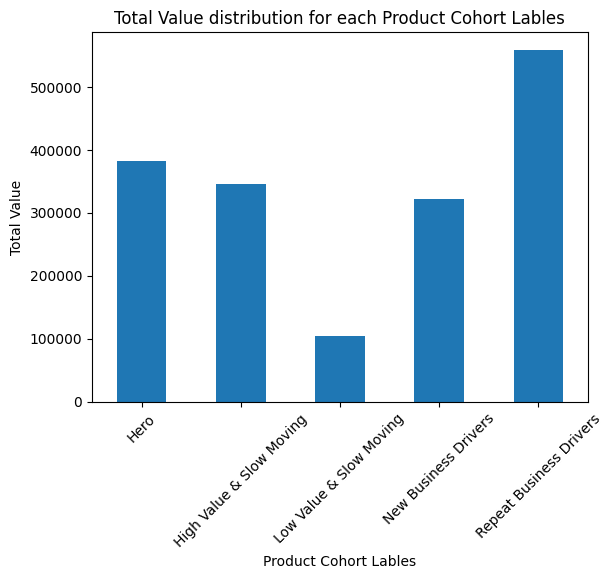

In [190]:
get_component_2("2023-w44", "Total_Value", "Product_Cohort_Lables")

In [85]:
current_week_dataframe = pd.concat([result_df_melted_1, curr_week_df], axis=0)
current_week_dataframe = current_week_dataframe.sort_values(by='WeekCount', ascending=True)
current_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Current Week Value'}, inplace=True)
keys_list = list(averages_dict.keys())
current_week_dataframe = current_week_dataframe[current_week_dataframe['WeekCount'].isin(keys_list)]

In [86]:
last_8_week_dataframe = pd.concat([result_df_melted_2, avg_week_df], axis=0)
last_8_week_dataframe = last_8_week_dataframe.sort_values(by='WeekCount', ascending=True)
last_8_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Last 8 Week Value'}, inplace=True)

In [87]:
merged_dataframe = pd.merge(current_week_dataframe, last_8_week_dataframe, on=['WeekCount', 'Variables'], how='left')
merged_dataframe = merged_dataframe.fillna(0)
primary_explanatory_vars = ['Total_Orders', 'No_of_Repeat_Users', 'AOV_Contribution', 'No_of_New_Users(First_Time_Users)', '90_Day_Retention']
target_vars = ["Total_Value"]
merged_dataframe.loc[merged_dataframe['Variables'].isin(target_vars), 'Tag'] = 'Target_Variable'
merged_dataframe.loc[merged_dataframe['Variables'].isin(primary_explanatory_vars), 'Tag'] = 'Primary_Explanatory'
merged_dataframe.loc[merged_dataframe['Variables'].isin(formatted_combinations), 'Tag'] = 'Secondary_Explanatory'
merged_dataframe['Difference'] = merged_dataframe['Current Week Value'] - merged_dataframe['Last 8 Week Value']

In [88]:
new_df_1 = merged_dataframe[merged_dataframe["Tag"] == "Secondary_Explanatory"]
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
0,2021-w42,Champions-Repeat Business Drivers,1399.0,2798.00,Secondary_Explanatory,-1399.00
1,2021-w42,Recent & Loyals-Hero,0.0,0.00,Secondary_Explanatory,0.00
2,2021-w42,Champions-Low Value & Slow Moving,4197.0,1399.00,Secondary_Explanatory,2798.00
3,2021-w42,Champions-High Value & Slow Moving,1399.0,0.00,Secondary_Explanatory,1399.00
4,2021-w42,New-Hero,0.0,2420.20,Secondary_Explanatory,-2420.20
...,...,...,...,...,...,...
3523,2023-w51,Champions-Repeat Business Drivers,900.0,16628.00,Secondary_Explanatory,-15728.00
3524,2023-w51,Champions-New Business Drivers,16628.0,0.00,Secondary_Explanatory,16628.00
3530,2023-w51,Churned (Repeat Use)-New Business Drivers,0.0,0.00,Secondary_Explanatory,0.00
3532,2023-w51,Churned (Single Use Only)-High Value & Slow Mo...,0.0,35866.25,Secondary_Explanatory,-35866.25


In [89]:
new_df_1[['User_Cohort_Lables', 'Product_Cohort_Lables']] = new_df_1['Variables'].str.split('-', expand=True)

In [90]:
grouped_by_week_delta = new_df_1.groupby('WeekCount')
dataframes_by_week = {}
for week, group in grouped_by_week_delta:
    dataframes_by_week[week] = group.drop(columns='WeekCount').copy()

In [91]:
def week_metric_user_product_split(week, parameter):
  week_df = dataframes_by_week[week]
  pivot_df = week_df.pivot_table(index='User_Cohort_Lables', columns='Product_Cohort_Lables', values=parameter, aggfunc='sum')
  return pivot_df
df_output_delta = week_metric_user_product_split("2023-w44", "Difference")

In [92]:
df_output_Week

Product Cohort Lables,Hero,High Value & Slow Moving,Low Value & Slow Moving,New Business Drivers,Repeat Business Drivers
User_Cohort_Label,,,,,
Champions,97970.0,21544.0,77247.0,1424.0,26402.0
Churned (Repeat Use),2000.0,0.0,2000.0,0.0,2000.0
Churned (Single Use Only),0.0,0.0,0.0,0.0,0.0
New,105860.0,43432.0,73456.0,15745.0,85662.0
Recent & Loyals,0.0,0.0,0.0,0.0,0.0


In [93]:
df_output_delta

Product_Cohort_Lables,Hero,High Value & Slow Moving,Low Value & Slow Moving,New Business Drivers,Repeat Business Drivers
User_Cohort_Lables,,,,,
Champions,71220.000,85020.000000,-104630.000,131767.666667,165641.750
Churned (Repeat Use),-105923.600,-76437.666667,-92750.000,-27608.250000,-8805.250
Churned (Single Use Only),-40672.500,-35774.625000,-31558.750,-8937.375000,-5839.375
New,150121.250,1484.875000,-78605.375,-54279.625000,93623.500
Recent & Loyals,-78830.875,-93904.875000,-63289.625,-86274.875000,-52578.750


In [184]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference,User_Cohort_Lables,Product_Cohort_Lables
0,2021-w42,Champions-Repeat Business Drivers,1399.0,2798.00,Secondary_Explanatory,-1399.00,Champions,Repeat Business Drivers
1,2021-w42,Recent & Loyals-Hero,0.0,0.00,Secondary_Explanatory,0.00,Recent & Loyals,Hero
2,2021-w42,Champions-Low Value & Slow Moving,4197.0,1399.00,Secondary_Explanatory,2798.00,Champions,Low Value & Slow Moving
3,2021-w42,Champions-High Value & Slow Moving,1399.0,0.00,Secondary_Explanatory,1399.00,Champions,High Value & Slow Moving
4,2021-w42,New-Hero,0.0,2420.20,Secondary_Explanatory,-2420.20,New,Hero
...,...,...,...,...,...,...,...,...
3523,2023-w51,Champions-Repeat Business Drivers,900.0,16628.00,Secondary_Explanatory,-15728.00,Champions,Repeat Business Drivers
3524,2023-w51,Champions-New Business Drivers,16628.0,0.00,Secondary_Explanatory,16628.00,Champions,New Business Drivers
3530,2023-w51,Churned (Repeat Use)-New Business Drivers,0.0,0.00,Secondary_Explanatory,0.00,Churned (Repeat Use),New Business Drivers
3532,2023-w51,Churned (Single Use Only)-High Value & Slow Mo...,0.0,35866.25,Secondary_Explanatory,-35866.25,Churned (Single Use Only),High Value & Slow Moving


In [95]:
df_output_delta.sum().sum()

-347822.35

In [96]:
delta_df = merged_dataframe[merged_dataframe["WeekCount"] == "2023-w44"]
selected_row = delta_df.loc[(delta_df['WeekCount'] == "2023-w44") & (delta_df['Variables'] == "Total_Value")]
selected_row

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
3315,2023-w44,Total_Value,1714868.0,2062690.35,Target_Variable,-347822.35


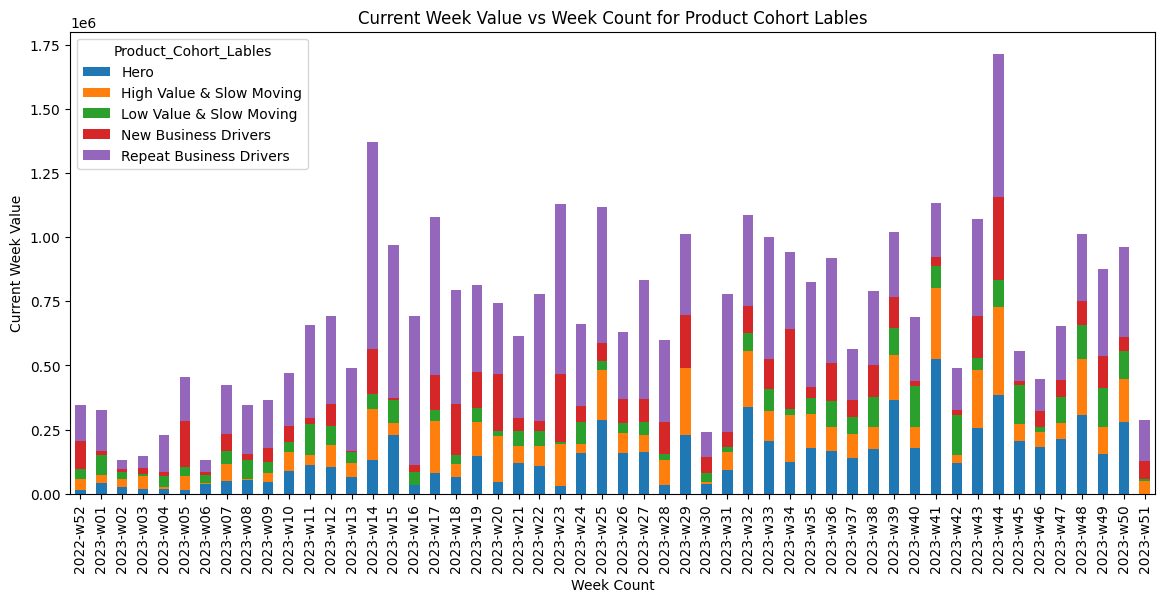

In [78]:
df_agg = new_df_1.groupby(['WeekCount', 'Product_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df = df_agg.pivot(index='WeekCount', columns='Product_Cohort_Lables', values='Current Week Value')
pivot_df = pivot_df.tail(52)
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for Product Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax.tick_params(axis='x')
plt.show()